In [35]:
import json
import shap
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models
from torch.utils.data import DataLoader


from trainer import ISICClassifier
from dataloader import loader
from utils import plot_cm, plot_feature_map

In [2]:
seed_everything(2, True)

Seed set to 2


2

# Image Sample

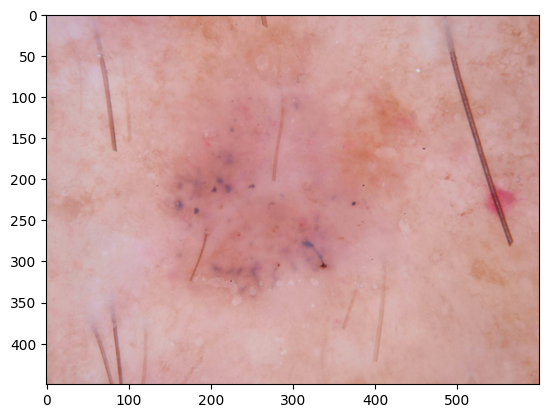

In [3]:
image = Image.open(str('DATA/BCC/ISIC_0024331.jpg'))
plt.imshow(image)

# Multiclass classification

### Loading data

In [4]:
DATA_DIR = r'DATA'
#same as before, just chaning classification type to binary
train_dataset, validation_dataset, test_dataset, classes, class_counts = loader(data_path=DATA_DIR, classification_type='multiclass')

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, persistent_workers=True, num_workers=4)
validation_dataloader = DataLoader(validation_dataset, batch_size=64, persistent_workers=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=64, persistent_workers=True, num_workers=4)  

del train_dataset
del validation_dataset
del test_dataset

### Initializing Train loop with pytorch lightning - Setting Tensorboard to log the Experiment
##### batch_size = 64, epoch = 20

In [5]:
chk_path = r'Experiments\resnet'
#8 classes
model = ISICClassifier(model_name='resnet50', num_classes=8, weights=models.ResNet50_Weights.IMAGENET1K_V2)

checkpoint_callback = ModelCheckpoint(
                dirpath=chk_path,
                monitor='val_loss',
                save_top_k=1,
                filename='best-{epoch}-{val_loss:.2f}'
            )

logger = TensorBoardLogger(save_dir='Experiments\logs', name='20epoch_multiclass_resnet50', version=1)

pl_trainer = Trainer(max_epochs = 20, accelerator='gpu', devices=1, precision="16-mixed", default_root_dir=chk_path, logger=logger, enable_progress_bar=True, log_every_n_steps = 1, callbacks=checkpoint_callback)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Train

In [6]:
pl_trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                  | Params
----------------------------------------------------
0 | model     | ResNet                | 23.5 M
1 | f1        | MulticlassF1Score     | 0     
2 | auroc     | MulticlassAUROC       | 0     
3 | recall    | MulticlassRecall      | 0     
4 | accuracy  | MulticlassAccuracy    | 0     
5 | precision | MulticlassPrecision   | 0     
6 | specifity | MulticlassSpecificity | 0     
----------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.098    Total estimated mode

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score


Epoch 19: 100%|██████████| 238/238 [01:57<00:00,  2.03it/s, v_num=1, train_loss=0.257, train_accuracy=0.900, val_loss_step=0.297, val_accuracy_step=0.900, val_loss_epoch=1.720, val_accuracy_epoch=0.659, validation_loss_epoch_end=1.250, validation_acc_epoch_end=0.625, train_loss_epoch_end=0.536, train_acc_epoch_end=0.807] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 238/238 [01:57<00:00,  2.03it/s, v_num=1, train_loss=0.257, train_accuracy=0.900, val_loss_step=0.297, val_accuracy_step=0.900, val_loss_epoch=1.720, val_accuracy_epoch=0.659, validation_loss_epoch_end=1.250, validation_acc_epoch_end=0.625, train_loss_epoch_end=0.536, train_acc_epoch_end=0.807]


### Test

In [7]:
pl_trainer.test(dataloaders=test_dataloader)

c:\Users\gangu\.conda\envs\torch-gpu\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at E:\Studies\Mina\Experiments\resnet\best-epoch=3-val_loss=0.87.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at E:\Studies\Mina\Experiments\resnet\best-epoch=3-val_loss=0.87.ckpt


Testing DataLoader 0: 100%|██████████| 80/80 [00:16<00:00,  4.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  test_Specifity_epoch      0.9554823637008667
   test_accuracy_epoch      0.6883757710456848
    test_auroc_epoch        0.7492702007293701
      test_f1_epoch         0.6883757710456848
  test_precision_epoch      0.6883757710456848
    test_recall_epoch       0.6883757710456848
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy_epoch': 0.6883757710456848,
  'test_auroc_epoch': 0.7492702007293701,
  'test_precision_epoch': 0.6883757710456848,
  'test_recall_epoch': 0.6883757710456848,
  'test_f1_epoch': 0.6883757710456848,
  'test_Specifity_epoch': 0.9554823637008667}]

#### Predictions

In [8]:
predictions = pl_trainer.predict(model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 80/80 [00:16<00:00,  4.99it/s]


# Binary Classification

## Load data

In [10]:
DATA_DIR = r'DATA'
#same as before, just chaning classification type to binary
train_dataset, validation_dataset, test_dataset, classes, class_counts = loader(data_path=DATA_DIR, classification_type='binary')

b_train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
b_validation_dataloader = DataLoader(validation_dataset, batch_size=64)
b_test_dataloader = DataLoader(test_dataset, batch_size=64)  

### Initializing Train loop with pytorch lightning - Setting Tensorboard to log the Experiment
##### batch_size = 64, epoch = 20

In [11]:
chk_path = r'Experiments\resnet'
#8 classes
model = ISICClassifier(model_name='resnet50', num_classes=2)

checkpoint_callback = ModelCheckpoint(
                dirpath=chk_path,
                monitor='val_loss',
                save_top_k=1,
                filename='best-{epoch}-{val_loss:.2f}'
            )

logger = TensorBoardLogger(save_dir='Experiments\logs', name='20epoch_binary_resnet50', version=1)

pl_trainer = Trainer(max_epochs = 20, accelerator='gpu', devices=1, precision="16-mixed", default_root_dir=chk_path, logger=logger, enable_progress_bar=True, log_every_n_steps = 1, callbacks=checkpoint_callback)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Train

In [12]:
pl_trainer.fit(model, train_dataloaders=b_train_dataloader, val_dataloaders=b_validation_dataloader)

c:\Users\gangu\.conda\envs\torch-gpu\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:630: Checkpoint directory E:\Studies\Mina\Experiments\resnet exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 23.5 M
1 | f1        | BinaryF1Score     | 0     
2 | auroc     | BinaryAUROC       | 0     
3 | recall    | BinaryRecall      | 0     
4 | accuracy  | BinaryAccuracy    | 0     
5 | precision | BinaryPrecision   | 0     
6 | specifity | BinarySpecificity | 0     
------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\gangu\.conda\envs\torch-gpu\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\gangu\.conda\envs\torch-gpu\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/238 [00:00<?, ?it/s] 

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score


Epoch 19: 100%|██████████| 238/238 [04:51<00:00,  0.82it/s, v_num=1, train_loss=0.155, train_accuracy=0.933, val_loss_step=0.514, val_accuracy_step=0.800, val_loss_epoch=0.148, val_accuracy_epoch=0.963, validation_loss_epoch_end=0.153, validation_acc_epoch_end=0.963, train_loss_epoch_end=0.141, train_acc_epoch_end=0.965] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 238/238 [04:51<00:00,  0.82it/s, v_num=1, train_loss=0.155, train_accuracy=0.933, val_loss_step=0.514, val_accuracy_step=0.800, val_loss_epoch=0.148, val_accuracy_epoch=0.963, validation_loss_epoch_end=0.153, validation_acc_epoch_end=0.963, train_loss_epoch_end=0.141, train_acc_epoch_end=0.965]


#### TEST

In [13]:
pl_trainer.test(dataloaders=b_test_dataloader)

c:\Users\gangu\.conda\envs\torch-gpu\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at E:\Studies\Mina\Experiments\resnet\best-epoch=16-val_loss=0.14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at E:\Studies\Mina\Experiments\resnet\best-epoch=16-val_loss=0.14.ckpt
c:\Users\gangu\.conda\envs\torch-gpu\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 80/80 [00:58<00:00,  1.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  test_Specifity_epoch      0.9993919134140015
   test_accuracy_epoch      0.9648707509040833
    test_auroc_epoch        0.7439620494842529
      test_f1_epoch        0.006315373815596104
  test_precision_epoch     0.012630747631192207
    test_recall_epoch      0.004210249520838261
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy_epoch': 0.9648707509040833,
  'test_auroc_epoch': 0.7439620494842529,
  'test_precision_epoch': 0.012630747631192207,
  'test_recall_epoch': 0.004210249520838261,
  'test_f1_epoch': 0.006315373815596104,
  'test_Specifity_epoch': 0.9993919134140015}]

#### Predictions

In [14]:
b_predictions = pl_trainer.predict(model, dataloaders=b_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\gangu\.conda\envs\torch-gpu\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 80/80 [00:56<00:00,  1.41it/s]


#### Confusion Matrics

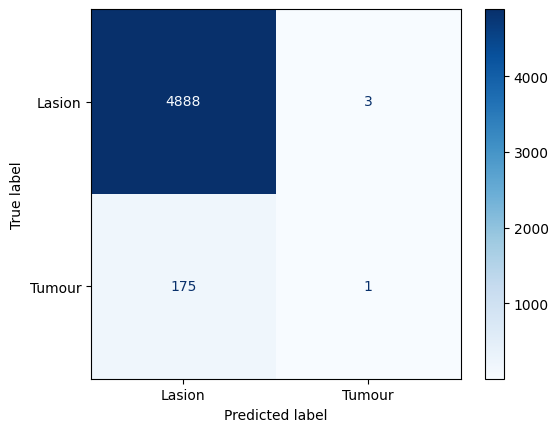

In [15]:
plot_cm(b_predictions)

# FEATURE MAP VISUAlIZATION

In [49]:
from torchvision import transforms, models

transform = transforms.Compose([transforms.Resize((450, 600)), transforms.ColorJitter(), transforms.ToTensor(), transforms.Normalize(mean=0., std=1.)])
device = 'cuda'
import torch
from torch import nn

def plot_feature_map(model, image):
    # we will save the conv layer weights in this list
    model_weights =[]
    #we will save the conv layers in this list
    conv_layers = []
    # get all the model children as list
    model_children = list(model.children())
    #counter to keep count of the conv layers
    counter = 0
    #append all the conv layers and their respective wights to the list
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            counter+=1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
        elif type(model_children[i]) == nn.Sequential:
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == nn.Conv2d:
                        counter+=1
                        model_weights.append(child.weight)
                        conv_layers.append(child)
        print(f"Total convolution layers: {counter}")
        print("conv_layers")

    image = transform(image)
    print(f"Image shape before: {image.shape}")
    image = image.unsqueeze(0)
    print(f"Image shape after: {image.shape}")
    image = image.to(device)    
    outputs = []
    names = []
    for layer in conv_layers[0:]:
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))
    print(len(outputs))
    #print feature_maps
    for feature_map in outputs:
        print(feature_map.shape)

    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    for fm in processed:
        print(fm.shape)

    fig = plt.figure(figsize=(30, 50))
    for i in range(len(processed)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(names[i].split('(')[0], fontsize=30)
    plt.savefig(str('plots/feature_maps.jpg'), bbox_inches='tight')

#temp_model = ISICClassifier('resnet50')
#temp_model = temp_model.load_from_checkpoint('Experiments\resnet\best-epoch=16-val_loss=0.14.ckpt')
plot_feature_map(model, image)

Total convolution layers: 0
conv_layers
Total convolution layers: 0
conv_layers
Total convolution layers: 0
conv_layers
Total convolution layers: 0
conv_layers
Total convolution layers: 0
conv_layers
Total convolution layers: 0
conv_layers
Total convolution layers: 0
conv_layers
Image shape before: torch.Size([3, 450, 600])
Image shape after: torch.Size([1, 3, 450, 600])
0


<Figure size 3000x5000 with 0 Axes>

# Explainability